## Langmuir probe Piecewise Fitting
[Langmuir Probe on Wikipedia](https://en.wikipedia.org/wiki/Langmuir_probe)  
 
$I(V) = I ^{sat} (e^{\frac{V-V_{float}}{T_e}} - 1)$  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from scipy.optimize import curve_fit
# %matplotlib notebook
%matplotlib inline

In [2]:
#filename = 'data-files/langmuir-data.csv'
filename = 'https://raw.githubusercontent.com/bernardocarvalho/python-plasma-science/main/data-files/langmuir-data.csv'
data = read_csv(filename, sep=',')

In [3]:
# X exp. values (Voltage)
voltageRaw = data['Voltage'].values
# Y exp. values (Current)
currentRaw = data['Current'].values

### Simple Linear Fitting 

In [4]:
# Define Simple Linear Fit Function
def fLinear(x, b_, m_):
    return m_ * x + b_

In [5]:
print(f'Total number of points = {voltageRaw.size:d}')
# Select here data Min, Max points
Vmin = -100
Vlow  = voltageRaw[voltageRaw > Vmin]
Vmax = 100
voltage = Vlow[Vlow < Vmax]

# Y exp. values 
Ilow  = currentRaw[voltageRaw > Vmin]
current = Ilow[Vlow < Vmax]

popt, pcov = curve_fit(fLinear, voltage, current)
perr = np.sqrt(np.diag(pcov))
fitted_current = fLinear(voltage, *popt)
rmse = np.sqrt(
    np.sum((current - fitted_current) ** 2) )
print(f'b = {popt[0]:.2g} uA, m = {popt[1]:.3g} uA / V')

Total number of points = 117
b = 2.9 uA, m = 0.743 uA / V


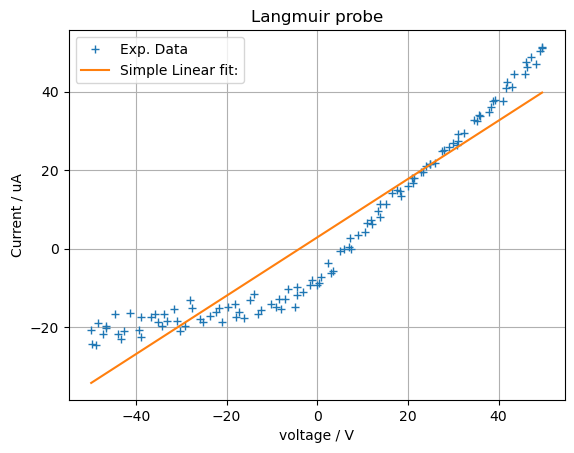

In [6]:
plt.figure()
plt.plot(voltage, current, '+', label='Exp. Data')
plt.plot(voltage, fitted_current, label='Simple Linear fit:')

plt.xlabel("voltage / V")
plt.ylabel("Current / uA")
plt.grid(True)
plt.title("Langmuir probe")
plt.legend()
plt.show()

### Piecewise Fitting 

In [7]:
# Modeling Functions. x is the indepedent variable. x_, y_ are the parameters to be fitted
def Flinear(x, x_, y_, k_):
    return k_ * (x - x_) + y_

def Fexp(x, x_, y_, k_, T_):
    return y_ + k_ * (np.exp((x - x_)/T_) - 1.0)

In [8]:
# Piecewise Fit Function writen with Numpy
# See https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
def piecewise_current(x, Vfloat, Ifloat, k0,  Amp, Te,  Vp, Ie):
    conds = [x < Vfloat, 
             (x >= Vfloat) & (x < Vp), 
             x >= Vp]
    funcs = [lambda x: Flinear(x, Vfloat, Ifloat, k0),
             lambda x: Fexp(x, Vfloat, Ifloat, Amp, Te),
             lambda x: Flinear(x, Vp, Fexp(Vp, Vfloat, Ifloat, Amp, Te), Ie)]
    return np.piecewise(x, conds, funcs)

MeanSqrError = 0.43 (uA)^2


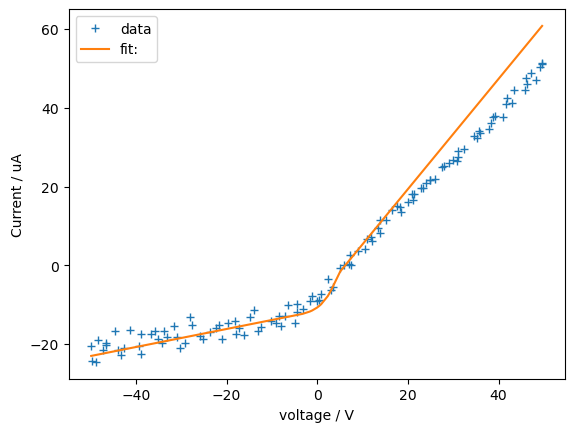

In [9]:
#              Vfloat, Ifloat,    k0,      Amp, Te,  Vp,     Ie)
pmanual = np.array([-3.25, -12.34, 0.229, 0.837, 3.0, 4.39, 1.4])
#_Temp   3,229306089
#_Isat   0,229112219
#_Vfloat -3,244936
#_offset 0,837388668
#_Ie   1,14030739
#_Vp  4,39316906
#_b	-12,34301396
adjust_current = piecewise_current(voltage, *pmanual)
rmse = np.sqrt(np.sum((current - adjust_current)**2) ) / voltage.size
print(f'MeanSqrError = {rmse:.2g} (uA)^2')
fig2, ax2 = plt.subplots(1)
ax2.plot(voltage, current, '+', label='data')
ax2.plot(voltage, adjust_current, label='fit:')
ax2.legend()
ax2.set_xlabel('voltage / V')
ax2.set_ylabel('Current / uA')
plt.show(block=True)

# print(f'MeanSqrError = {rmse:.2g} (uA)^2')


In [10]:
# Optimized Fit
# p0 argument is the Initial Guess for the parameter 
#pguess = np.array([-1, -6.34, 0.229, 0.837, 3.0, 2, 2])
pguess = pmanual

popt, pcov = curve_fit(piecewise_current, voltage, current, p0=pguess)
perr = np.sqrt(np.diag(pcov))
fitted_current = piecewise_current(voltage, *popt)
rmse = np.sqrt(np.sum((current - fitted_current)**2) ) / voltage.size
#        Vfloat, Ifloat, k0,  Amp, Te,  Vp, Ie)
print(f'Vfloat = {popt[0]:.2g} V, Ifloat = {popt[1]:.2g} V , k0 = {popt[2]:.2g} uA/V ')
print(f'Amp = {popt[3]:.2g} uA, Te = {popt[4]:.2g} eV , Vp = {popt[5]:.2g} V , Ie = {popt[6]:.2g} uA/V')
print(f'MeanSqrError = {rmse:.2g} (uA)^2')
# Vfloat = -12 V, Ifloat = -15 V , k0 = 0.18 uA/V 
# Amp = 0.87 uA, Te = 6.3 eV , Vp = 5.1 V , Ie = 1.1 uA/V
# MeanSqrError = 0.14 (uA)^2

Vfloat = -9.4 V, Ifloat = -14 V , k0 = 0.18 uA/V 
Amp = 3.2 uA, Te = 9.1 eV , Vp = 5.9 V , Ie = 1.1 uA/V
MeanSqrError = 0.14 (uA)^2


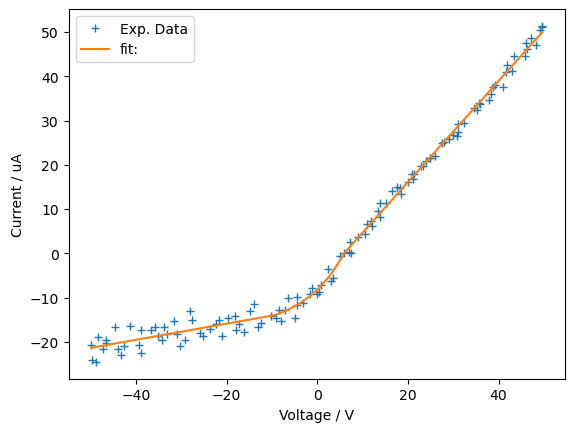

In [11]:
# Plot chosen data and fit results
fig2, ax2 = plt.subplots(1)
ax2.plot(voltage, current, '+', label='Exp. Data')
ax2.plot(voltage, fitted_current, label='fit:')
ax2.legend()
ax2.set_xlabel('Voltage / V')
ax2.set_ylabel('Current / uA')
plt.show(block=True)
#plt.title("Langmuir probe")